In [1]:
import os

import matplotlib.pyplot as plt
import torch
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from tempo2.data.datasets import finetune_dataset_jup
from tempo2.models import TempoLinear
from torchvision.models import ResNet34_Weights, resnet34
from torchvision.transforms import (CenterCrop, Compose, Grayscale,
                                    InterpolationMode, Normalize, Resize,
                                    ToTensor)
from zennit.attribution import Gradient, SmoothGrad
from zennit.composites import (EpsilonAlpha2Beta1, EpsilonAlpha2Beta1Flat,
                               EpsilonGammaBox, EpsilonPlus, EpsilonPlusFlat)
from zennit.image import imgify, imsave
from zennit.torchvision import ResNetCanonizer

In [2]:
MODEL_NAME = "vanilla.pth"

In [3]:
# load models
weights_tp = torch.load(f'../../model_zoo/{MODEL_NAME}')
model_tp = TempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_tp.load_state_dict(weights_tp)
model_tp.requires_grad = True
_ = model_tp.eval()

weights_bl = torch.load('../../model_zoo/baseline.pth')
model_bl = TempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_bl.load_state_dict(weights_bl)
model_bl.requires_grad = True
_ = model_bl.eval()

In [4]:
def get_relevance(model, data, num_classes):
    """
    Computes the relevance attributions for input images given a model.
    """

    with torch.no_grad():
        pred = torch.argmax(model(data).flatten()).item()

    canonizer = ResNetCanonizer()

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    # choose a target class for the attribution (label 437 is lighthouse)
    target = torch.eye(num_classes)[[pred]]

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(data, target)

    relevance = attribution.sum(1)

    return pred, relevance

In [5]:
# Load test-set
test_loader = finetune_dataset_jup(train=False, batch_size=1)
normalize = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # imagenet normalization, also applied during tempo training
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [6]:
class_map = {l:i for l, i in zip('ABCDEFGHIKLMNOPQRSTUVWXY', range(24))}
inv_class_map = {v: k for k, v in class_map.items()}

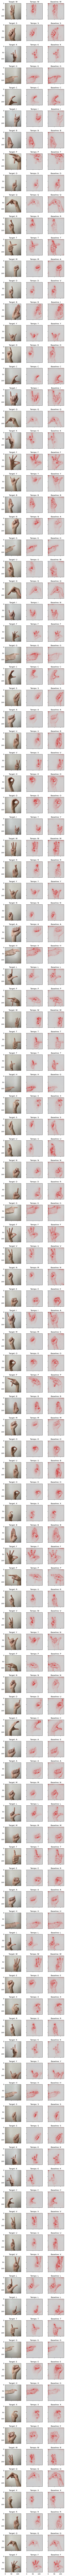

In [7]:
fig = plt.figure(figsize=(300., 300.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(test_loader.dataset.__len__(), 3),
                 axes_pad=0.5,
                 )

grid = chunker(grid, 3)
for i, (ax, (im, lbl)) in enumerate(zip(grid, test_loader)):
    img_n = normalize(im)
    pred_tp, relevance_tp = get_relevance(model_tp, img_n, 24)
    pred_bl, relevance_bl = get_relevance(model_bl, img_n, 24)

    img_hm_tp = imgify(relevance_tp, symmetric=True, cmap='0000d0,80:d0d0d0,d00000')

    img_hm_bl = imgify(relevance_bl, symmetric=True, cmap='0000d0,80:d0d0d0,d00000')

    gt_label = inv_class_map[lbl.item()]

    ax[0].set_title(f'Target: {gt_label}')
    ax[1].set_title(f'Tempo: {inv_class_map[pred_tp]}')
    ax[2].set_title(f'Baseline: {inv_class_map[pred_bl]}')

    im = im[0]
    ax[0].imshow(im.permute(1,2,0))
    ax[1].imshow(img_hm_tp)
    ax[2].imshow(img_hm_bl)

    imsave(f"../../supplementary_material/all_heatmaps/{gt_label}_tempo_{i}.png", relevance_tp, symmetric=True, cmap='0000d0,80:d0d0d0,d00000')
    imsave(f"../../supplementary_material/all_heatmaps/{gt_label}_baseline_{i}.png", relevance_bl, symmetric=True, cmap='0000d0,80:d0d0d0,d00000')

plt.show()